In [73]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.linalg import svd
import io
import requests


> Loading and Preprocessing the Image

In [74]:
image_path = 'plane.jpg'  # Update with your file path
img = Image.open(image_path).convert('L')  # Convert to grayscale

In [75]:
width, height = img.size
print(f"Original dimensions: {width}x{height}")

Original dimensions: 512x512


In [90]:
if width % 8 != 0 or height % 8 != 0:
    new_width = (width // 8) * 8
    new_height = (height // 8) * 8
    img = img.resize((new_width, new_height))
    print(f"Adjusted dimensions: {new_width}x{new_height}")


In [91]:
img_array = np.array(img, dtype=np.float64)

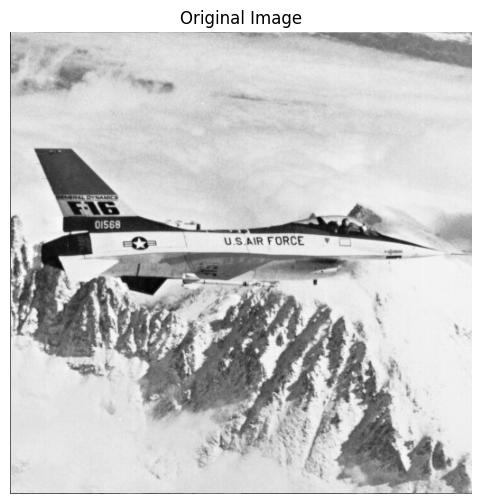

In [92]:
# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

>Implementing the Block-wise SVD Function

In [93]:
def compress_block(block, k):
   
    # Apply SVD to the block
    U, sigma, Vt = svd(block)
    
    # Retain only top-k singular values
    U_k = U[:, :k]
    sigma_k = sigma[:k]
    Vt_k = Vt[:k, :]
    
    # Reconstruct the block
    reconstructed_block = U_k @ np.diag(sigma_k) @ Vt_k
    
    return reconstructed_block

In [94]:
def compress_image(img_array, k):
   
    height, width = img_array.shape
    compressed_img = np.zeros_like(img_array)
    
    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = img_array[i:i+8, j:j+8]
            compressed_block = compress_block(block, k)
            compressed_img[i:i+8, j:j+8] = compressed_block
    
    return compressed_img

>Compression Analysis

In [95]:
def calculate_compression_ratio(k):
   
    original_size = 64  # 8x8 block
    compressed_size = k * (8 + 8 + 1)  # k*(8+8+1)
    return original_size / compressed_size


In [96]:
def calculate_reconstruction_error(original, reconstructed):
    """
    Calculate Frobenius norm of the difference between original and reconstructed images.
    """
    return np.linalg.norm(original - reconstructed, 'fro')

In [97]:
def calculate_psnr(original, reconstructed):
    """
    Calculate Peak Signal-to-Noise Ratio.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [98]:
# Analyze compression for each k value
k_values = range(1, 9)
compression_ratios = []
reconstruction_errors = []
psnr_values = []
compressed_images = []

for k in k_values:
    # Compress the image
    compressed_img = compress_image(img_array, k)
    compressed_images.append(compressed_img)
    
    # Calculate metrics
    compression_ratios.append(calculate_compression_ratio(k))
    reconstruction_errors.append(calculate_reconstruction_error(img_array, compressed_img))
    psnr_values.append(calculate_psnr(img_array, compressed_img))
    
    print(f"k={k}: Compression Ratio={compression_ratios[-1]:.4f}, PSNR={psnr_values[-1]:.4f} dB")

k=1: Compression Ratio=3.7647, PSNR=29.0344 dB
k=2: Compression Ratio=1.8824, PSNR=35.9619 dB
k=3: Compression Ratio=1.2549, PSNR=42.4752 dB
k=4: Compression Ratio=0.9412, PSNR=48.7951 dB
k=5: Compression Ratio=0.7529, PSNR=56.9992 dB
k=6: Compression Ratio=0.6275, PSNR=67.3005 dB
k=7: Compression Ratio=0.5378, PSNR=81.4783 dB
k=8: Compression Ratio=0.4706, PSNR=293.6858 dB


>Visualization

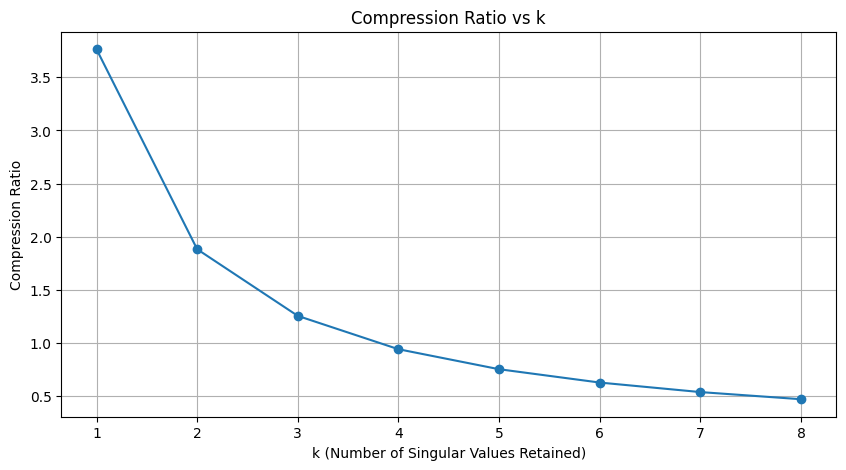

In [99]:
# Plot compression ratio vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, compression_ratios, marker='o', linestyle='-')
plt.xlabel('k (Number of Singular Values Retained)')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs k')
plt.grid(True)
plt.show()


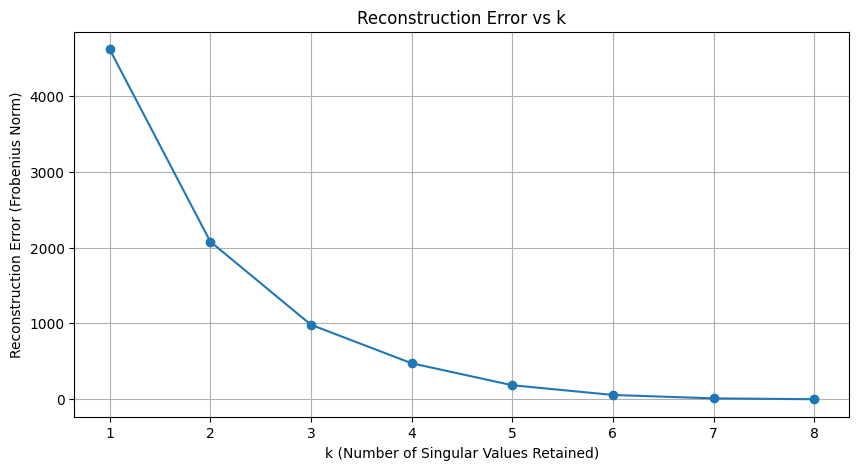

In [100]:
# Plot reconstruction error vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, reconstruction_errors, marker='o', linestyle='-')
plt.xlabel('k (Number of Singular Values Retained)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.title('Reconstruction Error vs k')
plt.grid(True)
plt.show()


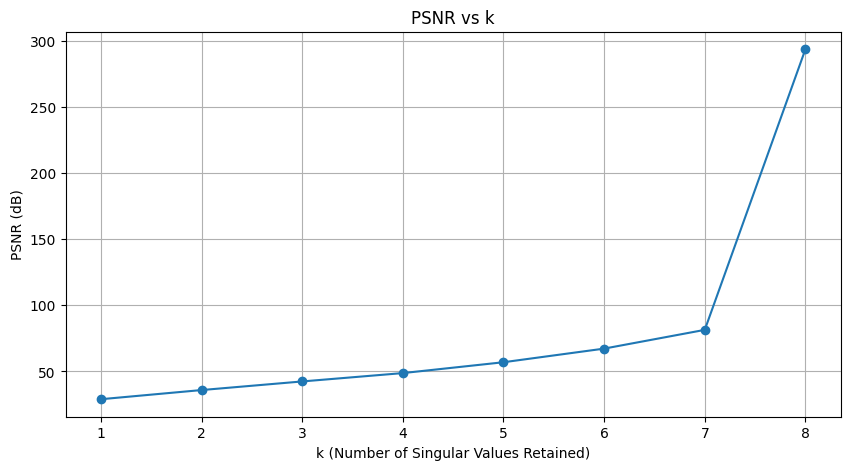

In [101]:
# Plot PSNR vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, psnr_values, marker='o', linestyle='-')
plt.xlabel('k (Number of Singular Values Retained)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs k')
plt.grid(True)
plt.show()


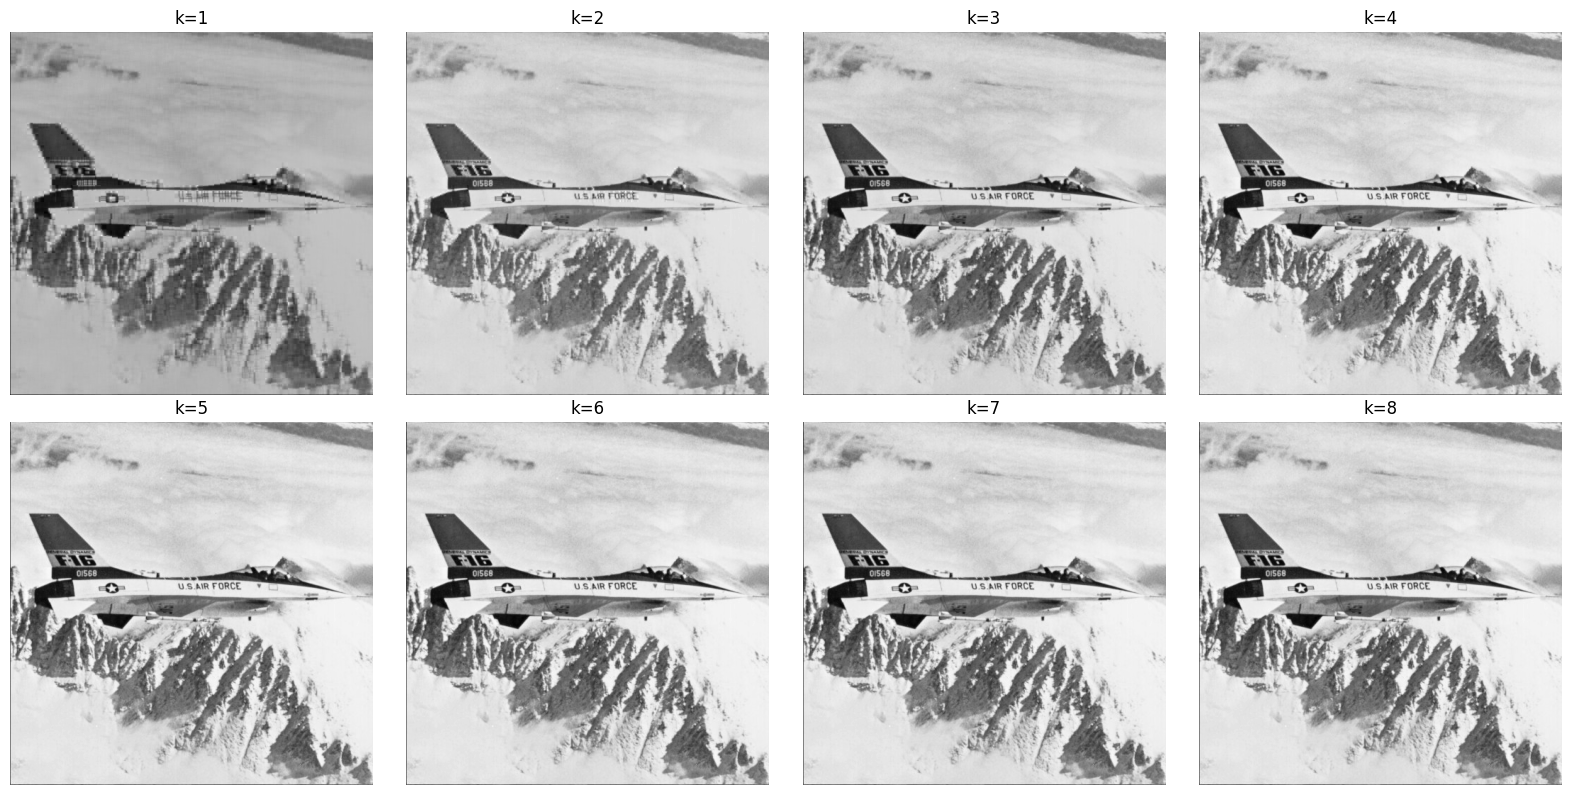

In [102]:
# Display compressed images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, k in enumerate(k_values):
    axes[i].imshow(compressed_images[i], cmap='gray')
    axes[i].set_title(f'k={k}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

>Saving the Compressed Images

In [103]:
# Save compressed images
for k, compressed_img in zip(k_values, compressed_images):
    plt.imsave(f'compressed_bobcat_k{k}.png', compressed_img, cmap='gray')